<a href="https://colab.research.google.com/github/sangche/mlclass/blob/master/dqn/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [조니코드](https://raw.githubusercontent.com/johnnycode8/gym_solutions/refs/heads/main/cartpole_q.py)

- step1 : run(is_training=True, ...)

- step2 : run(is_training=False, ...)

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

def run(is_training=True, render=False):

    env = gym.make('CartPole-v1', render_mode='human' if render else None)

    # Divide position, velocity, pole angle, and pole angular velocity into segments
    pos_space = np.linspace(-2.4, 2.4, 10)
    vel_space = np.linspace(-4, 4, 10)
    ang_space = np.linspace(-.2095, .2095, 10)
    ang_vel_space = np.linspace(-4, 4, 10)

    if(is_training):
        q = np.zeros((len(pos_space)+1, len(vel_space)+1, len(ang_space)+1, len(ang_vel_space)+1, env.action_space.n)) # init a 11x11x11x11x2 array
    else:
        f = open('cartpole.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    learning_rate_a = 0.1 # alpha or learning rate
    discount_factor_g = 0.99 # gamma or discount factor.

    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 0.00001 # epsilon decay rate
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = []

    i = 0

    # for i in range(episodes):
    while(True):

        state = env.reset()[0]      # Starting position, starting velocity always 0
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)
        state_a = np.digitize(state[2], ang_space)
        state_av = np.digitize(state[3], ang_vel_space)

        terminated = False          # True when reached goal

        rewards=0

        while(not terminated and rewards < 10000):

            if is_training and rng.random() < epsilon:
                # Choose random action  (0=go left, 1=go right)
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state_p, state_v, state_a, state_av, :])

            new_state,reward,terminated,_,_ = env.step(action)
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)
            new_state_a = np.digitize(new_state[2], ang_space)
            new_state_av= np.digitize(new_state[3], ang_vel_space)

            if is_training:
                q[state_p, state_v, state_a, state_av, action] = q[state_p, state_v, state_a, state_av, action] + learning_rate_a * (
                    reward + discount_factor_g*np.max(q[new_state_p, new_state_v, new_state_a, new_state_av,:]) - q[state_p, state_v, state_a, state_av, action]
                )

            state = new_state
            state_p = new_state_p
            state_v = new_state_v
            state_a = new_state_a
            state_av= new_state_av

            rewards+=reward

            if not is_training and rewards%100==0:
                print(f'Episode: {i}  Rewards: {rewards}')

        rewards_per_episode.append(rewards)
        mean_rewards = np.mean(rewards_per_episode[len(rewards_per_episode)-100:])

        if is_training and i%100==0:
            print(f'Episode: {i} {rewards}  Epsilon: {epsilon:0.2f}  Mean Rewards {mean_rewards:0.1f}')

        if mean_rewards>1000:
            break

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        i+=1

    env.close()

    # Save Q table to file
    if is_training:
        f = open('cartpole.pkl','wb')
        pickle.dump(q, f)
        f.close()

    mean_rewards = []
    for t in range(i):
        mean_rewards.append(np.mean(rewards_per_episode[max(0, t-100):(t+1)]))
    plt.plot(mean_rewards)
    plt.savefig(f'cartpole.png')

if __name__ == '__main__':
    run(is_training=True, render=False) # step1

    # run(is_training=False, render=True) # step2


Episode: 0 53.0  Epsilon: 1.00  Mean Rewards 53.0
Episode: 100 23.0  Epsilon: 1.00  Mean Rewards 22.7
Episode: 200 24.0  Epsilon: 1.00  Mean Rewards 22.2
Episode: 300 16.0  Epsilon: 1.00  Mean Rewards 22.0
Episode: 400 20.0  Epsilon: 1.00  Mean Rewards 22.8
Episode: 500 20.0  Epsilon: 1.00  Mean Rewards 23.0
Episode: 600 23.0  Epsilon: 0.99  Mean Rewards 21.0
Episode: 700 25.0  Epsilon: 0.99  Mean Rewards 21.6
Episode: 800 33.0  Epsilon: 0.99  Mean Rewards 22.1
Episode: 900 34.0  Epsilon: 0.99  Mean Rewards 22.1
Episode: 1000 16.0  Epsilon: 0.99  Mean Rewards 22.8
Episode: 1100 44.0  Epsilon: 0.99  Mean Rewards 21.5
Episode: 1200 19.0  Epsilon: 0.99  Mean Rewards 23.2
Episode: 1300 11.0  Epsilon: 0.99  Mean Rewards 22.5
Episode: 1400 16.0  Epsilon: 0.99  Mean Rewards 23.2
Episode: 1500 16.0  Epsilon: 0.99  Mean Rewards 21.9
Episode: 1600 26.0  Epsilon: 0.98  Mean Rewards 23.6
Episode: 1700 31.0  Epsilon: 0.98  Mean Rewards 21.2
Episode: 1800 52.0  Epsilon: 0.98  Mean Rewards 21.0
Episo

# CartPole TensorFlow

by this [guy](https://jonghyunho.github.io/reinforcement/learning/cartpole-reinforcement-learning.html)

In [1]:
import gym
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.optimizers import Adam

# 상태가 입력, Q 함수가 출력인 인공신경망 생성

In [2]:
class DQN(tf.keras.Model):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.fc1 = Dense(24, activation='relu')
        self.fc2 = Dense(24, activation='relu')
        self.fc_out = Dense(action_size, kernel_initializer=RandomUniform(-1e-3, 1e-3))

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q

In [8]:
# CartPole 환경에서 agent 역할을 하는 DQNAgent 클래스이다. CartPole 환경에서는 4가지의 상태와 2가지의 행동으로 이루어진다.

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # DQN 알고리즘을 구동하기 위한 하이퍼파라미터 값을 설정한다.
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        self.memory = deque(maxlen=2000)

        # model 과 target_model 두 개의 인공신경망을 생성한다.
        # Q 함수를 학습하기 위해 model의 파라미터가 학습 도중 갱신되는데, 이 파라미터의 변경으로 인하여 정답으로 간주되는 다음 상태의 Q 함수도 함께 변경이 된다.
        # 이를 막기 위해 다음 상태의 Q 함수를 위한 별도의 target_model을 분리하여 사용한다.
        self.model = DQN(action_size)
        self.target_model = DQN(action_size)
        # self.optimizer = Adam(lr=self.learning_rate)
        self.optimizer = Adam(self.learning_rate)

        self.update_target_model()

    # update_target_model은 target_model의 가중치를 model의 가중치로 업데이트 하는 함수이다.
    # 일정 주기로 타겟 흔들림을 해결하기 위해 분리된 model 과 target_model 네트워크의 가중치를 일치시킨다.
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # epsilon을 이용하여 탐험(Exploration)과 활용(Exploitation)의 비율을 조정한다.
    # 학습된 정보만을 이용하여 action 을 선택하게 되면 새로운 환경에 대해 경험해 볼 수 없기 때문에
    # 랜덤한 수를 골라 e 보다 작으면 랜덤, 그렇지 않으면 학습된 모델을 사용하는 E-greedy 정책을 사용한다.
    def choose_action(self, state):
        return random.randrange(self.action_size) if (np.random.rand() <= self.epsilon) else np.argmax(self.model.predict(state))

    # 샘플 간 correlation 을 줄이기 위해 리플레이 메모리에 저장된 데이터를 랜덤하게 섞어 훈련에 사용할 미니 배치 데이터를 생성한다.
    # 벨만 최적 방정식을 이용하여 계산된 정답에 해당하는 targets 와 예상 값 predicts 의 차이를 줄여 나가는 경사 하강법으로 학습을 진행한다
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.array([sample[0][0] for sample in mini_batch])
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])

        model_params = self.model.trainable_variables

        with tf.GradientTape() as tape:
            predicts = self.model(states)
            one_hot_action = tf.one_hot(actions, self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)

            target_predicts = self.target_model(next_states)
            target_predicts = tf.stop_gradient(target_predicts)

            max_q = np.amax(target_predicts, axis=-1)
            targets = rewards + (1 - dones) * self.discount_factor * max_q
            loss = tf.reduce_mean(tf.square(targets - predicts))

        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))

In [ ]:
# CartPole-v1 환경과 그 환경에서 학습을 진행하게 될 DQNAgent를 생성한다.

if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []
    score_avg = 0

    # episode 가 시작될 때마다 환경을 초기화한다.
    num_episode = 300
    for e in range(num_episode):
        done = False
        score = 0

        state = env.reset()
        state = state.reshape(1, -1)

        # 현재 상태에서 action 을 하나 선택하여 한 스텝 진행한다.
        # 그 결과로 받은 보상을 현재 상태와 선택한 행동과 함께 리플레이 메모리에 저장한다.
        # 리플레이 메모리가 일정 크기 이상으로 저장되면 매 스텝마다 학습할 수 있도록 한다.
        while not done:
            env.render()

            action = agent.choose_action(state)

            next_state, reward, done, info = env.step(action)
            next_state = next_state.reshape(1, -1)

            score += reward
            reward = 0.1 if not done or score == 500 else -1

            # agent.remember(state, action, reward, next_state, done)
            agent.memory.append((state, action, reward, next_state, done))

            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            state = next_state

            # 한 episode 가 완료될 때마다 target_model 을 model의 가중치와 일치하도록 동기화하고, score 와 모델의 가중치를 저장한다.
            if done:
                agent.update_target_model()

                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print('episode: {:3d} | score avg {:3.2f} | memory length: {:4d} | epsilon: {:.4f}'.format(e, score_avg, len(agent.memory), agent.epsilon))

                scores.append(score_avg)
                episodes.append(e)
                plt.plot(episodes, scores, 'b')
                plt.xlabel('episode')
                plt.ylabel('average score')
                plt.savefig('cartpole_graph.png')

                if score_avg  > 400:
                    agent.model.save_weights('./model', save_format='tf')
                    sys.exit()

# Working?? code

In [ ]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

EPISODES = 300


# 카트폴 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        self.load_model = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        # 리플레이 메모리, 최대 크기 2000
        self.memory = deque(maxlen=2000)

        # 모델과 타깃 모델 생성
        self.model = self.build_model()
        self.target_model = self.build_model()

        # 타깃 모델 초기화
        self.update_target_model()

        if self.load_model:
            self.model.load_weights("./cartpole_dqn_trained.h5")

    # 상태가 입력, 큐함수가 출력인 인공신경망 생성
    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(self.learning_rate))
        return model

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []

        for i in range(self.batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])

        # 현재 상태에 대한 모델의 큐함수
        # 다음 상태에 대한 타깃 모델의 큐함수
        target = self.model.predict(states)
        target_val = self.target_model.predict(next_states)

        # 벨만 최적 방정식을 이용한 업데이트 타깃
        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (
                    np.amax(target_val[i]))

        self.model.fit(states, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)


if __name__ == "__main__":
    # CartPole-v1 환경, 최대 타임스텝 수가 500
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # DQN 에이전트 생성
    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        # env 초기화
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # 현재 상태로 행동을 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # 에피소드가 중간에 끝나면 -100 보상
            reward = reward if not done or score == 499 else -100

            # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
            agent.append_sample(state, action, reward, next_state, done)
            # 매 타임스텝마다 학습
            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            score += reward
            state = next_state

            if done:
                # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
                agent.update_target_model()

                score = score if score == 500 else score + 100
                # 에피소드마다 학습 결과 출력
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./cartpole_dqn.png")
                print("episode:", e, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)

                # 이전 10개 에피소드의 점수 평균이 490보다 크면 학습 중단
                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    agent.model.save_weights("./cartpole_dqn.h5")
                    sys.exit()

# another [cartpole](https://www.youtube.com/watch?v=KMjQmG5Uzis), [written](https://aleksandarhaber.com/q-learning-in-python-with-tests-in-cart-pole-openai-gym-environment-reinforcement-learning-tutorial/)

In [33]:
import numpy as np

class Q_Learning:
    ###########################################################################
    #   START - __init__ function
    ###########################################################################
    # INPUTS:
    # env - Cart Pole environment
    # alpha - step size
    # gamma - discount rate
    # epsilon - parameter for epsilon-greedy approach
    # numberEpisodes - total number of simulation episodes

    # numberOfBins - this is a 4 dimensional list that defines the number of grid points
    # for state discretization
    # that is, this list contains number of bins for every state entry,
    # we have 4 entries, that is,
    # discretization for cart position, cart velocity, pole angle, and pole angular velocity

    # lowerBounds - lower bounds (limits) for discretization, list with 4 entries:
    # lower bounds on cart position, cart velocity, pole angle, and pole angular velocity

    # upperBounds - upper bounds (limits) for discretization, list with 4 entries:
    # upper bounds on cart position, cart velocity, pole angle, and pole angular velocity

    def __init__(self,env,alpha,gamma,epsilon,numberEpisodes,numberOfBins,lowerBounds,upperBounds):
        import numpy as np

        self.env=env
        self.alpha=alpha
        self.gamma=gamma
        self.epsilon=epsilon
        self.actionNumber=env.action_space.n
        self.numberEpisodes=numberEpisodes
        self.numberOfBins=numberOfBins
        self.lowerBounds=lowerBounds
        self.upperBounds=upperBounds

        # this list stores sum of rewards in every learning episode
        self.sumRewardsEpisode=[]

        # this matrix is the action value function matrix
        self.Qmatrix=np.random.uniform(low=0, high=1, size=(numberOfBins[0],numberOfBins[1],numberOfBins[2],numberOfBins[3],self.actionNumber))


    ###########################################################################
    #   END - __init__ function
    ###########################################################################

    ###########################################################################
    # START: function "returnIndexState"
    # for the given 4-dimensional state, and discretization grid defined by
    # numberOfBins, lowerBounds, and upperBounds, this function will return
    # the index tuple (4-dimensional) that is used to index entries of the
    # of the QvalueMatrix


    # INPUTS:
    # state - state list/array, 4 entries:
    # cart position, cart velocity, pole angle, and pole angular velocity

    # OUTPUT: 4-dimensional tuple defining the indices of the QvalueMatrix
    # that correspond to "state" input

    ###############################################################################
    def returnIndexState(self,state):
        position =      state[0]
        velocity =      state[1]
        angle    =      state[2]
        angularVelocity=state[3]

        cartPositionBin=np.linspace(self.lowerBounds[0],self.upperBounds[0],self.numberOfBins[0])
        cartVelocityBin=np.linspace(self.lowerBounds[1],self.upperBounds[1],self.numberOfBins[1])
        poleAngleBin=np.linspace(self.lowerBounds[2],self.upperBounds[2],self.numberOfBins[2])
        poleAngleVelocityBin=np.linspace(self.lowerBounds[3],self.upperBounds[3],self.numberOfBins[3])

        indexPosition=np.maximum(np.digitize(state[0],cartPositionBin)-1,0)
        indexVelocity=np.maximum(np.digitize(state[1],cartVelocityBin)-1,0)
        indexAngle=np.maximum(np.digitize(state[2],poleAngleBin)-1,0)
        indexAngularVelocity=np.maximum(np.digitize(state[3],poleAngleVelocityBin)-1,0)

        return tuple([indexPosition,indexVelocity,indexAngle,indexAngularVelocity])
    ###########################################################################
    #   END - function "returnIndexState"
    ###########################################################################

    ###########################################################################
    #    START - function for selecting an action: epsilon-greedy approach
    ###########################################################################
    # this function selects an action on the basis of the current state
    # INPUTS:
    # state - state for which to compute the action
    # index - index of the current episode
    def selectAction(self,state,index):

        # first 500 episodes we select completely random actions to have enough exploration
        if index<500:
            return np.random.choice(self.actionNumber)

        # Returns a random real number in the half-open interval [0.0, 1.0)
        # this number is used for the epsilon greedy approach
        randomNumber=np.random.random()

        # after 7000 episodes, we slowly start to decrease the epsilon parameter
        if index>7000:
            self.epsilon=0.999*self.epsilon

        # if this condition is satisfied, we are exploring, that is, we select random actions
        if randomNumber < self.epsilon:
            # returns a random action selected from: 0,1,...,actionNumber-1
            return np.random.choice(self.actionNumber)

        # otherwise, we are selecting greedy actions
        else:
            # we return the index where Qmatrix[state,:] has the max value
            # that is, since the index denotes an action, we select greedy actions
            return np.random.choice(np.where(self.Qmatrix[self.returnIndexState(state)]==np.max(self.Qmatrix[self.returnIndexState(state)]))[0])
            # here we need to return the minimum index since it can happen
            # that there are several identical maximal entries, for example
            # import numpy as np
            # a=[0,1,1,0]
            # np.where(a==np.max(a))
            # this will return [1,2], but we only need a single index
            # that is why we need to have np.random.choice(np.where(a==np.max(a))[0])
            # note that zero has to be added here since np.where() returns a tuple
    ###########################################################################
    #    END - function selecting an action: epsilon-greedy approach
    ###########################################################################


    ###########################################################################
    #    START - function for simulating learning episodes
    ###########################################################################

    def simulateEpisodes(self):
        import numpy as np
        # here we loop through the episodes
        for indexEpisode in range(self.numberEpisodes):

            # list that stores rewards per episode - this is necessary for keeping track of convergence
            rewardsEpisode=[]

            # reset the environment at the beginning of every episode
            stateS=self.env.reset()
            stateS=list(stateS)

            print("Simulating episode {}".format(indexEpisode))


            # here we step from one state to another
            # this will loop until a terminal state is reached
            terminalState=False
            while not terminalState:
                # return a discretized index of the state

                stateSIndex=self.returnIndexState(stateS)

                # select an action on the basis of the current state, denoted by stateS
                actionA = self.selectAction(stateS,indexEpisode)

                # print("actionA", actionA)


                # here we step and return the state, reward, and boolean denoting if the state is a terminal state
                # prime means that it is the next state
                (stateSprime, reward, terminalState, _) = self.env.step(actionA)

                rewardsEpisode.append(reward)

                stateSprime=list(stateSprime)

                stateSprimeIndex=self.returnIndexState(stateSprime)

                # return the max value, we do not need actionAprime...
                QmaxPrime=np.max(self.Qmatrix[stateSprimeIndex])

                if not terminalState:
                    # stateS+(actionA,) - we use this notation to append the tuples
                    # for example, for stateS=(0,0,0,1) and actionA=(1,0)
                    # we have stateS+(actionA,)=(0,0,0,1,0)
                    error=reward+self.gamma*QmaxPrime-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)]=self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error
                else:
                    # in the terminal state, we have Qmatrix[stateSprime,actionAprime]=0
                    error=reward-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)]=self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error

                # set the current state to the next state
                stateS=stateSprime

            print("Sum of rewards {}".format(np.sum(rewardsEpisode)))
            self.sumRewardsEpisode.append(np.sum(rewardsEpisode))


    ###########################################################################
    #    END - function for simulating learning episodes
    ###########################################################################


    ###########################################################################
    #    START - function for simulating the final learned optimal policy
    ###########################################################################
    # OUTPUT:
    # env1 - created Cart Pole environment
    # obtainedRewards - a list of obtained rewards during time steps of a single episode

    # simulate the final learned optimal policy
    def simulateLearnedStrategy(self):
        import gym
        import time
        env1=gym.make('CartPole-v1',render_mode='human')
        currentState=env1.reset()
        env1.render()
        timeSteps=1000
        # obtained rewards at every time step
        obtainedRewards=[]

        for timeIndex in range(timeSteps):
            print(timeIndex)
            # select greedy actions
            actionInStateS=np.random.choice(np.where(self.Qmatrix[self.returnIndexState(currentState)]==np.max(self.Qmatrix[self.returnIndexState(currentState)]))[0])
            currentState, reward, terminated, truncated =env1.step(actionInStateS)
            obtainedRewards.append(reward)
            time.sleep(0.05)
            if (terminated):
                time.sleep(1)
                break
        return obtainedRewards,env1
    ###########################################################################
    #    END - function for simulating the final learned optimal policy
    ###########################################################################

    ###########################################################################
    #    START - function for simulating random actions many times
    #   this is used to evaluate the optimal policy and to compare it with a random policy
    ###########################################################################
    #  OUTPUT:
    # sumRewardsEpisodes - every entry of this list is a sum of rewards obtained by simulating the corresponding episode
    # env2 - created Cart Pole environment
    def simulateRandomStrategy(self):
        import gym
        import time
        import numpy as np
        env2=gym.make('CartPole-v1')
        currentState=env2.reset()
        env2.render()
        # number of simulation episodes
        episodeNumber=100
        # time steps in every episode
        timeSteps=1000
        # sum of rewards in each episode
        sumRewardsEpisodes=[]


        for episodeIndex in range(episodeNumber):
            rewardsSingleEpisode=[]
            initial_state=env2.reset()
            print(episodeIndex)
            for timeIndex in range(timeSteps):
                random_action=env2.action_space.sample()
                observation, reward, terminated, truncated =env2.step(random_action)
                rewardsSingleEpisode.append(reward)
                if (terminated):
                    break
            sumRewardsEpisodes.append(np.sum(rewardsSingleEpisode))
        return sumRewardsEpisodes,env2
    ###########################################################################
    #    END - function for simulating random actions many times
    ###########################################################################

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Sum of rewards 244.0
Simulating episode 12673
Sum of rewards 281.0
Simulating episode 12674
Sum of rewards 270.0
Simulating episode 12675
Sum of rewards 258.0
Simulating episode 12676
Sum of rewards 221.0
Simulating episode 12677
Sum of rewards 234.0
Simulating episode 12678
Sum of rewards 275.0
Simulating episode 12679
Sum of rewards 250.0
Simulating episode 12680
Sum of rewards 280.0
Simulating episode 12681
Sum of rewards 390.0
Simulating episode 12682
Sum of rewards 216.0
Simulating episode 12683
Sum of rewards 262.0
Simulating episode 12684
Sum of rewards 294.0
Simulating episode 12685
Sum of rewards 358.0
Simulating episode 12686
Sum of rewards 232.0
Simulating episode 12687
Sum of rewards 222.0
Simulating episode 12688
Sum of rewards 317.0
Simulating episode 12689
Sum of rewards 257.0
Simulating episode 12690
Sum of rewards 388.0
Simulating episode 12691
Sum of rewards 202.0
Simulating episode 12692
Sum of rewards 196.0
Simulating episode 1269

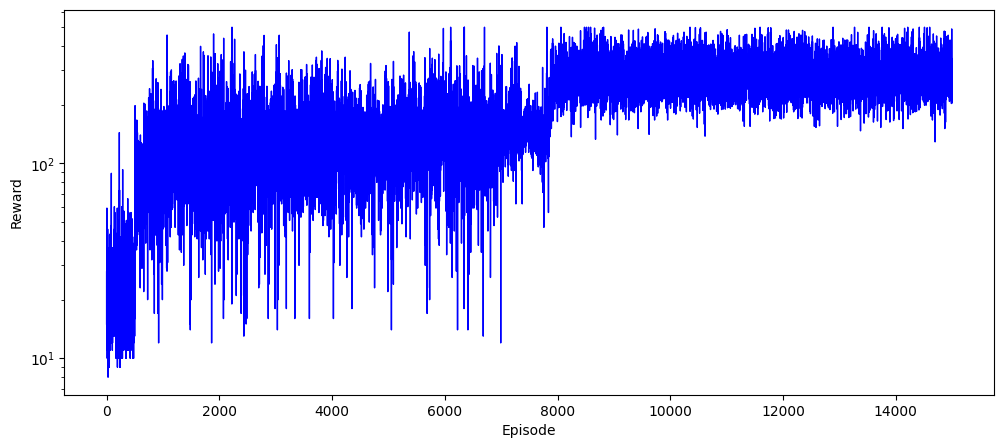

/usr/local/lib/python3.11/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


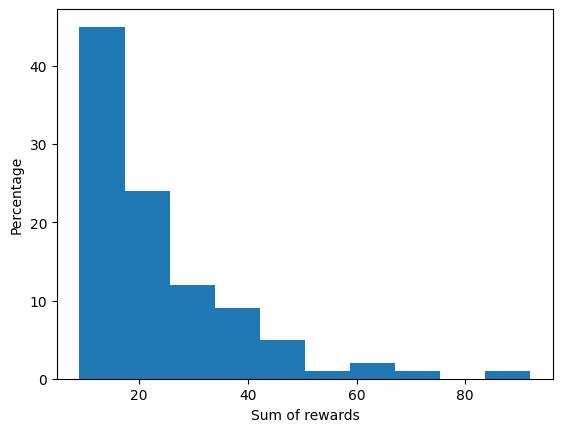

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [34]:
# classical gym
import gym
# instead of gym, import gymnasium
# import gymnasium as gym
import numpy as np
import time
import matplotlib.pyplot as plt

# import the class that implements the Q-Learning algorithm
# from functions import Q_Learning

#env=gym.make('CartPole-v1',render_mode='human')
env=gym.make('CartPole-v1')
state=env.reset()
#env.render()
#env.close()

# here define the parameters for state discretization
upperBounds=env.observation_space.high
lowerBounds=env.observation_space.low
cartVelocityMin=-3
cartVelocityMax=3
poleAngleVelocityMin=-10
poleAngleVelocityMax=10
upperBounds[1]=cartVelocityMax
upperBounds[3]=poleAngleVelocityMax
lowerBounds[1]=cartVelocityMin
lowerBounds[3]=poleAngleVelocityMin

numberOfBinsPosition=30
numberOfBinsVelocity=30
numberOfBinsAngle=30
numberOfBinsAngleVelocity=30
numberOfBins=[numberOfBinsPosition,numberOfBinsVelocity,numberOfBinsAngle,numberOfBinsAngleVelocity]

# define the parameters
alpha=0.1
gamma=1
epsilon=0.2
numberEpisodes=15000

# create an object
Q1=Q_Learning(env,alpha,gamma,epsilon,numberEpisodes,numberOfBins,lowerBounds,upperBounds)
# run the Q-Learning algorithm
Q1.simulateEpisodes()
# simulate the learned strategy
(obtainedRewardsOptimal,env1)=Q1.simulateLearnedStrategy()

plt.figure(figsize=(12, 5))
# plot the figure and adjust the plot parameters
plt.plot(Q1.sumRewardsEpisode,color='blue',linewidth=1)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.yscale('log')
plt.show()
plt.savefig('convergence.png')


# close the environment
env1.close()
# get the sum of rewards
np.sum(obtainedRewardsOptimal)

# now simulate a random strategy
(obtainedRewardsRandom,env2)=Q1.simulateRandomStrategy()
plt.hist(obtainedRewardsRandom)
plt.xlabel('Sum of rewards')
plt.ylabel('Percentage')
plt.savefig('histogram.png')
plt.show()

# run this several times and compare with a random learning strategy
(obtainedRewardsOptimal,env1)=Q1.simulateLearnedStrategy()

<div class="markdown-google-sans">
  <h1>Colab 시작 페이지</h1>
</div>

<div class="markdown-google-sans">
  <h2>&#40;신규&#41; Gemini API를 사용해 보세요</h2>
  <ul>
  <li><a href="https://makersuite.google.com/app/apikey">Generate a Gemini API key</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Talk_to_Gemini_with_Google%27s_Speech_to_Text_API.ipynb?utm_medium=link&utm_campaign=gemini">Talk to Gemini with the Speech-to-Text API</a></li>
  <li><a href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/tutorials/quickstart_colab.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API: Quickstart with Python</a></li>
  <li><a href="https://colab.research.google.com/notebooks/snippets/gemini.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API code sample</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Learning_with_Gemini_and_ChatGPT.ipynb?utm_medium=link&utm_campaign=gemini">Compare Gemini with ChatGPT</a></li>  
  <li><a href="https://colab.google/notebooks/?utm_medium=link&utm_campaign=gemini">More notebooks</a></li>
  </ul>
</div>


Colab에 이미 익숙하다면 이 동영상을 통해 양방향 테이블, 코드 실행 기록 보기, 명령어 팔레트에 관해 알아보세요.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  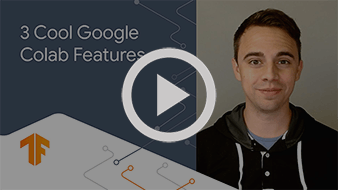
  </a>
</center>

<div class="markdown-google-sans">
  <h2>Colab이란?</h2>
</div>

Colaboratory&#40;줄여서 'Colab'이라고 함&#41;을 통해 브라우저 내에서 Python 스크립트를 작성하고 실행할 수 있습니다.
- 구성이 필요하지 않음
- 무료로 GPU 사용
- 간편한 공유

<strong>학생</strong>이든, <strong>데이터 과학자</strong>든, <strong>AI 연구원</strong>이든 Colab으로 업무를 더욱 간편하게 처리할 수 있습니다. <a href="https://www.youtube.com/watch?v=inN8seMm7UI">Colab 소개 영상</a>에서 자세한 내용을 확인하거나 아래에서 시작해 보세요.

<div class="markdown-google-sans">

## <strong>시작하기</strong>
</div>

지금 읽고 계신 문서는 정적 웹페이지가 아니라 코드를 작성하고 실행할 수 있는 대화형 환경인 <strong>Colab 메모장</strong>입니다.

예를 들어 다음은 값을 계산하여 변수로 저장하고 결과를 출력하는 간단한 Python 스크립트가 포함된 <strong>코드 셀</strong>입니다.

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

In [30]:
import numpy as np

class Q_Learning:
    ###########################################################################
    #   START - __init__ function
    ###########################################################################
    # INPUTS:
    # env - Cart Pole environment
    # alpha - step size
    # gamma - discount rate
    # epsilon - parameter for epsilon-greedy approach
    # numberEpisodes - total number of simulation episodes

    # numberOfBins - this is a 4 dimensional list that defines the number of grid points
    # for state discretization
    # that is, this list contains number of bins for every state entry,
    # we have 4 entries, that is,
    # discretization for cart position, cart velocity, pole angle, and pole angular velocity

    # lowerBounds - lower bounds (limits) for discretization, list with 4 entries:
    # lower bounds on cart position, cart velocity, pole angle, and pole angular velocity

    # upperBounds - upper bounds (limits) for discretization, list with 4 entries:
    # upper bounds on cart position, cart velocity, pole angle, and pole angular velocity

    def __init__(self,env,alpha,gamma,epsilon,numberEpisodes,numberOfBins,lowerBounds,upperBounds):
        import numpy as np

        self.env=env
        self.alpha=alpha
        self.gamma=gamma
        self.epsilon=epsilon
        self.actionNumber=env.action_space.n
        self.numberEpisodes=numberEpisodes
        self.numberOfBins=numberOfBins
        self.lowerBounds=lowerBounds
        self.upperBounds=upperBounds

        # this list stores sum of rewards in every learning episode
        self.sumRewardsEpisode=[]

        # this matrix is the action value function matrix
        self.Qmatrix=np.random.uniform(low=0, high=1, size=(numberOfBins[0],numberOfBins[1],numberOfBins[2],numberOfBins[3],self.actionNumber))


    ###########################################################################
    #   END - __init__ function
    ###########################################################################

    ###########################################################################
    # START: function "returnIndexState"
    # for the given 4-dimensional state, and discretization grid defined by
    # numberOfBins, lowerBounds, and upperBounds, this function will return
    # the index tuple (4-dimensional) that is used to index entries of the
    # of the QvalueMatrix


    # INPUTS:
    # state - state list/array, 4 entries:
    # cart position, cart velocity, pole angle, and pole angular velocity

    # OUTPUT: 4-dimensional tuple defining the indices of the QvalueMatrix
    # that correspond to "state" input

    ###############################################################################
    def returnIndexState(self,state):
        position =      state[0]
        velocity =      state[1]
        angle    =      state[2]
        angularVelocity=state[3]

        cartPositionBin=np.linspace(self.lowerBounds[0],self.upperBounds[0],self.numberOfBins[0])
        cartVelocityBin=np.linspace(self.lowerBounds[1],self.upperBounds[1],self.numberOfBins[1])
        poleAngleBin=np.linspace(self.lowerBounds[2],self.upperBounds[2],self.numberOfBins[2])
        poleAngleVelocityBin=np.linspace(self.lowerBounds[3],self.upperBounds[3],self.numberOfBins[3])

        indexPosition=np.maximum(np.digitize(state[0],cartPositionBin)-1,0)
        indexVelocity=np.maximum(np.digitize(state[1],cartVelocityBin)-1,0)
        indexAngle=np.maximum(np.digitize(state[2],poleAngleBin)-1,0)
        indexAngularVelocity=np.maximum(np.digitize(state[3],poleAngleVelocityBin)-1,0)

        return tuple([indexPosition,indexVelocity,indexAngle,indexAngularVelocity])
    ###########################################################################
    #   END - function "returnIndexState"
    ###########################################################################

    ###########################################################################
    #    START - function for selecting an action: epsilon-greedy approach
    ###########################################################################
    # this function selects an action on the basis of the current state
    # INPUTS:
    # state - state for which to compute the action
    # index - index of the current episode
    def selectAction(self,state,index):

        # first 500 episodes we select completely random actions to have enough exploration
        if index<500:
            return np.random.choice(self.actionNumber)

        # Returns a random real number in the half-open interval [0.0, 1.0)
        # this number is used for the epsilon greedy approach
        randomNumber=np.random.random()

        # after 7000 episodes, we slowly start to decrease the epsilon parameter
        if index>7000:
            self.epsilon=0.999*self.epsilon

        # if this condition is satisfied, we are exploring, that is, we select random actions
        if randomNumber < self.epsilon:
            # returns a random action selected from: 0,1,...,actionNumber-1
            return np.random.choice(self.actionNumber)

        # otherwise, we are selecting greedy actions
        else:
            # we return the index where Qmatrix[state,:] has the max value
            # that is, since the index denotes an action, we select greedy actions
            return np.random.choice(np.where(self.Qmatrix[self.returnIndexState(state)]==np.max(self.Qmatrix[self.returnIndexState(state)]))[0])
            # here we need to return the minimum index since it can happen
            # that there are several identical maximal entries, for example
            # import numpy as np
            # a=[0,1,1,0]
            # np.where(a==np.max(a))
            # this will return [1,2], but we only need a single index
            # that is why we need to have np.random.choice(np.where(a==np.max(a))[0])
            # note that zero has to be added here since np.where() returns a tuple
    ###########################################################################
    #    END - function selecting an action: epsilon-greedy approach
    ###########################################################################


    ###########################################################################
    #    START - function for simulating learning episodes
    ###########################################################################

    def simulateEpisodes(self):
        import numpy as np
        # here we loop through the episodes
        for indexEpisode in range(self.numberEpisodes):

            # list that stores rewards per episode - this is necessary for keeping track of convergence
            rewardsEpisode=[]

            # reset the environment at the beginning of every episode
            stateS=self.env.reset()
            stateS=list(stateS)

            print("Simulating episode {}".format(indexEpisode))


            # here we step from one state to another
            # this will loop until a terminal state is reached
            terminalState=False
            while not terminalState:
                # return a discretized index of the state

                stateSIndex=self.returnIndexState(stateS)

                # select an action on the basis of the current state, denoted by stateS
                actionA = self.selectAction(stateS,indexEpisode)

                # print("actionA", actionA)


                # here we step and return the state, reward, and boolean denoting if the state is a terminal state
                # prime means that it is the next state
                (stateSprime, reward, terminalState,_) = self.env.step(actionA)

                rewardsEpisode.append(reward)

                stateSprime=list(stateSprime)

                stateSprimeIndex=self.returnIndexState(stateSprime)

                # return the max value, we do not need actionAprime...
                QmaxPrime=np.max(self.Qmatrix[stateSprimeIndex])

                if not terminalState:
                    # stateS+(actionA,) - we use this notation to append the tuples
                    # for example, for stateS=(0,0,0,1) and actionA=(1,0)
                    # we have stateS+(actionA,)=(0,0,0,1,0)
                    error=reward+self.gamma*QmaxPrime-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)]=self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error
                else:
                    # in the terminal state, we have Qmatrix[stateSprime,actionAprime]=0
                    error=reward-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)]=self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error

                # set the current state to the next state
                stateS=stateSprime

            print("Sum of rewards {}".format(np.sum(rewardsEpisode)))
            self.sumRewardsEpisode.append(np.sum(rewardsEpisode))


    ###########################################################################
    #    END - function for simulating learning episodes
    ###########################################################################


    ###########################################################################
    #    START - function for simulating the final learned optimal policy
    ###########################################################################
    # OUTPUT:
    # env1 - created Cart Pole environment
    # obtainedRewards - a list of obtained rewards during time steps of a single episode

    # simulate the final learned optimal policy
    def simulateLearnedStrategy(self):
        import gym
        import time
        env1=gym.make('CartPole-v1',render_mode='human')
        currentState=env1.reset()
        env1.render()
        timeSteps=1000
        # obtained rewards at every time step
        obtainedRewards=[]

        for timeIndex in range(timeSteps):
            print(timeIndex)
            # select greedy actions
            actionInStateS=np.random.choice(np.where(self.Qmatrix[self.returnIndexState(currentState)]==np.max(self.Qmatrix[self.returnIndexState(currentState)]))[0])
            currentState, reward, terminated, truncated =env1.step(actionInStateS)
            obtainedRewards.append(reward)
            time.sleep(0.05)
            if (terminated):
                time.sleep(1)
                break
        return obtainedRewards,env1
    ###########################################################################
    #    END - function for simulating the final learned optimal policy
    ###########################################################################

    ###########################################################################
    #    START - function for simulating random actions many times
    #   this is used to evaluate the optimal policy and to compare it with a random policy
    ###########################################################################
    #  OUTPUT:
    # sumRewardsEpisodes - every entry of this list is a sum of rewards obtained by simulating the corresponding episode
    # env2 - created Cart Pole environment
    def simulateRandomStrategy(self):
        import gym
        import time
        import numpy as np
        env2=gym.make('CartPole-v1')
        currentState=env2.reset()
        env2.render()
        # number of simulation episodes
        episodeNumber=100
        # time steps in every episode
        timeSteps=1000
        # sum of rewards in each episode
        sumRewardsEpisodes=[]


        for episodeIndex in range(episodeNumber):
            rewardsSingleEpisode=[]
            initial_state=env2.reset()
            print(episodeIndex)
            for timeIndex in range(timeSteps):
                random_action=env2.action_space.sample()
                observation, reward, terminated, truncated =env2.step(random_action)
                rewardsSingleEpisode.append(reward)
                if (terminated):
                    break
            sumRewardsEpisodes.append(np.sum(rewardsSingleEpisode))
        return sumRewardsEpisodes,env2
    ###########################################################################
    #    END - function for simulating random actions many times
    ###########################################################################



위 셀의 코드를 실행하려면 셀을 클릭하여 선택한 후 코드 왼쪽의 실행 버튼을 누르거나 단축키 'Command/Ctrl+Enter'를 사용하세요. 셀을 클릭하면 코드 수정을 바로 시작할 수 있습니다.

특정 셀에서 정의한 변수를 나중에 다른 셀에서 사용할 수 있습니다.

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Colab 메모장을 사용하면 <strong>실행 코드</strong>와 <strong>서식 있는 텍스트</strong>를 <strong>이미지</strong>, <strong>HTML</strong>, <strong>LaTeX</strong> 등과 함께 하나의 문서로 통합할 수 있습니다. Colab 메모장을 만들면 Google Drive 계정에 저장됩니다. Colab 메모장을 간편하게 공유하여 동료나 친구들이 댓글을 달거나 수정하도록 할 수 있습니다. 자세히 알아보려면 <a href="/notebooks/basic_features_overview.ipynb">Colab 개요</a>를 참조하세요. 새 Colab 메모장을 만들려면 위의 파일 메뉴를 사용하거나 다음 링크로 이동하세요. <a href="http://colab.research.google.com#create=true">새 Colab 메모장 만들기</a>

Colab 메모장은 Colab에서 호스팅하는 Jupyter 메모장입니다. Jupyter 프로젝트에 관해 자세히 알아보려면 <a href="https://www.jupyter.org">jupyter.org</a>를 참조하세요.

<div class="markdown-google-sans">

## 데이터 과학
</div>

Colab을 통해 인기 있는 Python 라이브러리를 최대한 활용하여 데이터를 분석하고 시각화할 수 있습니다. 아래 코드 셀에서는 <strong>Numpy</strong>를 사용하여 임의의 데이터를 생성하고 <strong>매트플롯립</strong>으로 이를 시각화합니다. 셀을 클릭하면 코드 수정을 바로 시작할 수 있습니다.

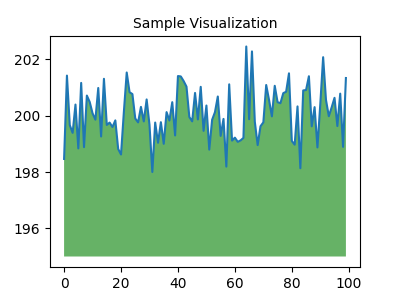

In [ ]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

Google Drive 계정에서 스프레드시트를 비롯한 데이터를 Colab 메모장으로 가져오거나 GitHub 등의 여러 다른 소스에서 데이터를 가져올 수 있습니다. Colab을 데이터 과학에 활용하는 방법과 데이터 가져오기에 관해 자세히 알아보려면 <a href="#working-with-data">데이터 사용하기</a> 아래 링크를 참조하세요.

<div class="markdown-google-sans">

## 머신러닝
</div>

Colab을 사용하면 <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb">코드 몇 줄</a>만으로 이미지 데이터세트를 가져오고, 이 데이터세트로 이미지 분류기를 학습시키며, 모델을 평가할 수 있습니다. Colab 메모장은 Google 클라우드 서버에서 코드를 실행하므로 사용 중인 컴퓨터의 성능과 관계없이 <a href="#using-accelerated-hardware">GPU 및 TPU</a>를 포함한 Google 하드웨어의 성능을 활용할 수 있습니다. 브라우저만 있으면 사용 가능합니다.

Colab은 다음과 같은 분야의 머신러닝 커뮤니티에서 널리 쓰이고 있습니다.
- TensorFlow 시작하기
- 신경망 개발 및 학습시키기
- TPU로 실험하기
- AI 연구 보급하기
- 튜토리얼 만들기

머신러닝 적용 사례를 보여 주는 Colab 메모장 샘플을 확인하려면 아래 <a href="#machine-learning-examples">머신러닝 예시</a>를 참조하세요.

<div class="markdown-google-sans">

## 추가 리소스

### Colab에서 메모장 사용하기

</div>

- [Colaboratory 개요](/notebooks/basic_features_overview.ipynb)
- [Markdown 가이드](/notebooks/markdown_guide.ipynb)
- [라이브러리 가져오기 및 종속 항목 설치하기](/notebooks/snippets/importing_libraries.ipynb)
- [GitHub에서 노트 저장 및 로드하기](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [대화형 양식](/notebooks/forms.ipynb)
- [대화형 위젯](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### 데이터로 작업하기
</div>

- [데이터 로드: 드라이브, 스프레드시트, Google Cloud Storage](/notebooks/io.ipynb)
- [차트: 데이터 시각화하기](/notebooks/charts.ipynb)
- [BigQuery 시작하기](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### 머신러닝 단기집중과정

<div>

다음은 Google 온라인 머신러닝 과정에서 가져온 일부 메모장입니다. <a href="https://developers.google.com/machine-learning/crash-course/">전체 과정 웹사이트</a>에서 자세한 내용을 확인하세요.
- [Pandas DataFrame 소개](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [합성 데이터를 사용하는 tf.keras 선형 회귀](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### 가속 하드웨어 사용하기
</div>

- [GPU를 사용한 TensorFlow](/notebooks/gpu.ipynb)
- [TPU를 사용한 TensorFlow](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### 추천 예시

</div>

- <a href="https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb">NeMo Voice Swap</a>: Nvidia의 NeMo 대화형 AI 툴킷을 사용하여 오디오 파일의 음성을 컴퓨터에서 생성된 음성으로 변환하세요.

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">이미지 분류기 재훈련</a>: 사전에 훈련된 이미지 분류기를 기반으로 꽃을 분류하기 위한 Keras 모델을 구축합니다.
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">텍스트 분류</a>: IMDB 영화 리뷰를 <em>긍정적인 리뷰</em> 또는 <em>부정적인 리뷰</em>로 분류합니다.
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">스타일 트랜스퍼</a>: 딥 러닝을 사용하여 이미지 간에 스타일을 전이시킵니다.
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Multilingual Universal Sentence Encoder Q&amp;A</a>: 머신러닝 모델을 사용하여 SQuAD 데이터 세트의 질문에 답변합니다.
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">동영상 보간 유형</a>: 동영상에서 첫 프레임과 마지막 프레임 사이에 발생한 내용을 예측합니다.
